# [Exploration 20] Conditional GAN

이번 프로젝트는 Conditional GAN을 활용한 이미지 채색이다.    
기존의 GAN은 인풋 데이터로 랜덤한 값을 넣어 랜덤한 이미지가 생성되었다면, CGAN은 conditional한 GAN을 조건으로 두어, input에 랜덤한 값과 동시에 내가 원하는 형식의 이미지를 동시에 넣음으로써 목표한 이미지가 생성되도록 하는 모델이다.

## Step 1. 데이터 불러오기

In [1]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


총 1000개의 데이터가 있으며 각각은 원본의 이미지와 스케치만 되어 있는 이미지가 쌍으로 되어있다.

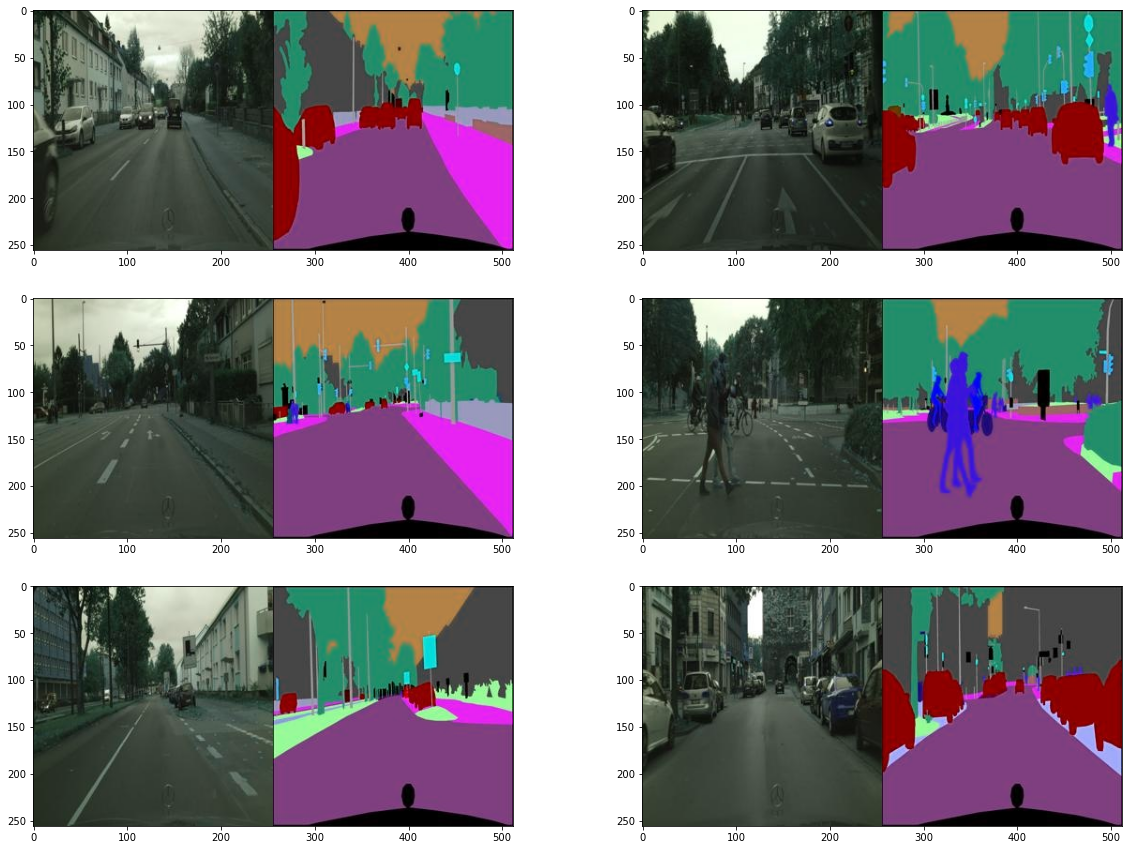

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)


쌍으로 되어 있는 이미지를 input과 target값으로 맞춰주기 위하여 이미지를 반으로 나눈다.

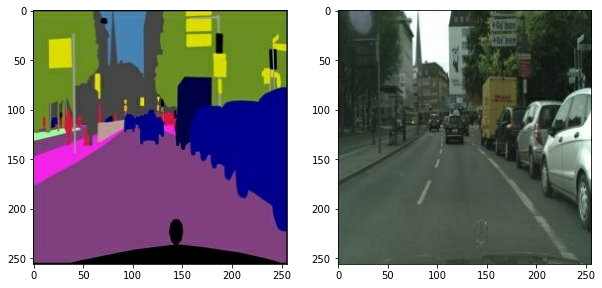

In [3]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

  
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

왼쪽에 input으로 들어갈 이미지, 오른쪽이 채색될 타겟 이미지이다.

## Step 2. Augmentation

앞서 확인하였던것과 같이 데이터는 총 1000개의 쌍으로 구성되어 있다.   
학습하기 위한 데이터가 현저히 부족하므로 augmentation을 통하여 데이터를 확보하도록 한다.

In [4]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

Augmentation을 적용할 수 있는 함수를 정의하고 아래와 같이 적용된 이미지를 확인해본다.

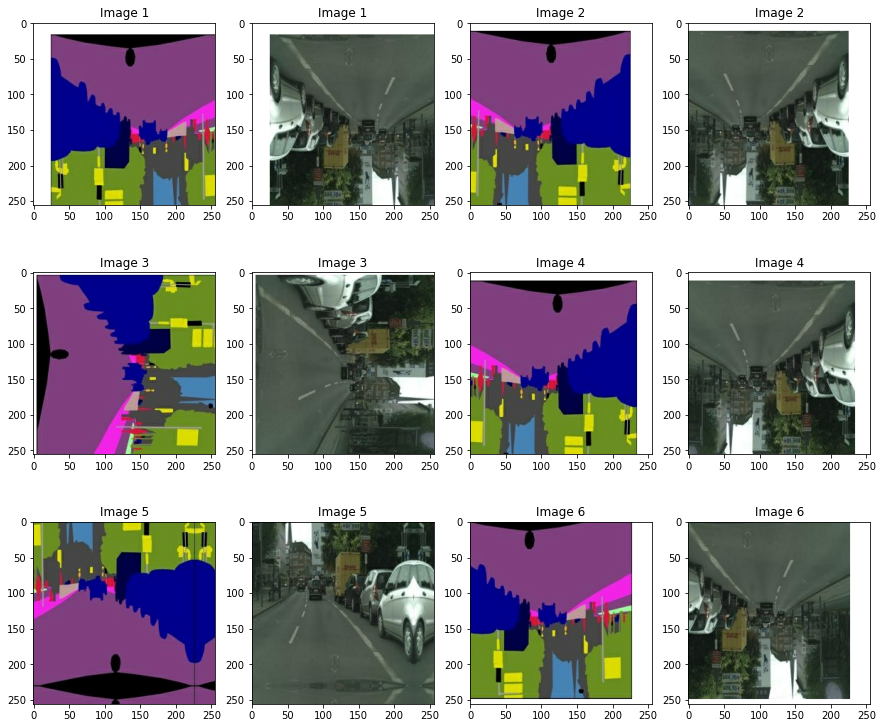

In [5]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1


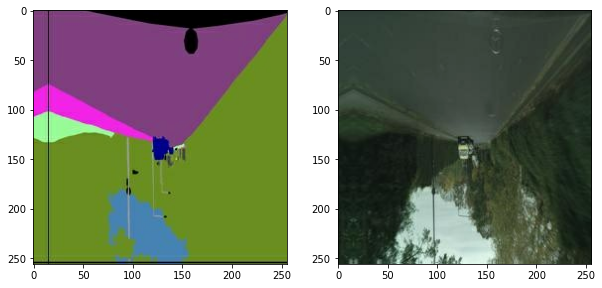

In [6]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

Augmentation이 잘 적용되는 것으로 확인된다.

## Step 3. (1) Generator 구현하기

이번 스텝에서는 GAN 모델을 구성하는데 필요한 첫번째 요소인 Generator를 구성한다.

### Encoder 구현

In [7]:
from tensorflow.keras import layers, Input, Model
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)


### Decoder 구현

In [8]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

### U-Net Generator 구현

In [9]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [10]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## Step 3. (2) Discriminator 구성하기

다음으로는 GAN의 두번째 요소인 Discriminator를 구현한다,

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [13]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### 테스트 시각화

GAN모델이 잘 돌아가는지 사알짝 확인해본다 ㅎ.ㅎ

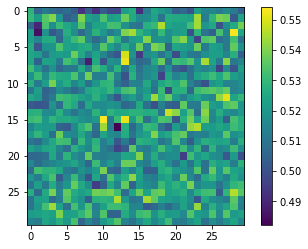

In [14]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 학습 및 테스트

생성자와 판별자에 각각 필요한 loss를 구성한 후 학습을 진행한다.

In [15]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [16]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [17]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [24]:
EPOCHS = 100

generator = UNetGenerator()
discriminator = Discriminator()

g_loss_ = []
l1_loss_ = []
d_loss_ = []


for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        g_loss_.append(g_loss)
        l1_loss_.append(l1_loss)
        d_loss_.append(d_loss_)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:0.6809                     
L1_loss:0.1673                     
Discriminator_loss:1.3793

EPOCH[1] - STEP[100]                     
Generator_loss:0.7870                     
L1_loss:0.1652                     
Discriminator_loss:1.2232

EPOCH[1] - STEP[150]                     
Generator_loss:1.0790                     
L1_loss:0.1902                     
Discriminator_loss:0.9833

EPOCH[1] - STEP[200]                     
Generator_loss:1.0890                     
L1_loss:0.1959                     
Discriminator_loss:0.8202

EPOCH[1] - STEP[250]                     
Generator_loss:1.3194                     
L1_loss:0.2012                     
Discriminator_loss:0.8579

EPOCH[2] - STEP[50]                     
Generator_loss:1.4497                     
L1_loss:0.1602                     
Discriminator_loss:0.6851

EPOCH[2] - STEP[100]                     
Generator_loss:2.1407                     
L1_loss:0.1644               

EPOCH[12] - STEP[100]                     
Generator_loss:0.8131                     
L1_loss:0.1877                     
Discriminator_loss:0.8423

EPOCH[12] - STEP[150]                     
Generator_loss:2.6956                     
L1_loss:0.1694                     
Discriminator_loss:0.8294

EPOCH[12] - STEP[200]                     
Generator_loss:0.7362                     
L1_loss:0.1485                     
Discriminator_loss:1.1556

EPOCH[12] - STEP[250]                     
Generator_loss:1.3750                     
L1_loss:0.1741                     
Discriminator_loss:0.8441

EPOCH[13] - STEP[50]                     
Generator_loss:0.8079                     
L1_loss:0.1790                     
Discriminator_loss:0.8833

EPOCH[13] - STEP[100]                     
Generator_loss:0.4596                     
L1_loss:0.1681                     
Discriminator_loss:1.4544

EPOCH[13] - STEP[150]                     
Generator_loss:1.8210                     
L1_loss:0.1683       

EPOCH[23] - STEP[150]                     
Generator_loss:1.6812                     
L1_loss:0.1702                     
Discriminator_loss:0.6556

EPOCH[23] - STEP[200]                     
Generator_loss:1.4230                     
L1_loss:0.1767                     
Discriminator_loss:1.1348

EPOCH[23] - STEP[250]                     
Generator_loss:1.7506                     
L1_loss:0.1530                     
Discriminator_loss:0.5519

EPOCH[24] - STEP[50]                     
Generator_loss:0.5044                     
L1_loss:0.1655                     
Discriminator_loss:1.5190

EPOCH[24] - STEP[100]                     
Generator_loss:0.7951                     
L1_loss:0.1567                     
Discriminator_loss:0.9630

EPOCH[24] - STEP[150]                     
Generator_loss:1.9423                     
L1_loss:0.1840                     
Discriminator_loss:1.0028

EPOCH[24] - STEP[200]                     
Generator_loss:0.6458                     
L1_loss:0.1700       

EPOCH[34] - STEP[200]                     
Generator_loss:1.4694                     
L1_loss:0.1703                     
Discriminator_loss:0.7049

EPOCH[34] - STEP[250]                     
Generator_loss:1.0830                     
L1_loss:0.1855                     
Discriminator_loss:0.6419

EPOCH[35] - STEP[50]                     
Generator_loss:1.3527                     
L1_loss:0.1693                     
Discriminator_loss:0.9438

EPOCH[35] - STEP[100]                     
Generator_loss:1.8755                     
L1_loss:0.1591                     
Discriminator_loss:0.9601

EPOCH[35] - STEP[150]                     
Generator_loss:0.8236                     
L1_loss:0.1830                     
Discriminator_loss:0.6825

EPOCH[35] - STEP[200]                     
Generator_loss:1.0477                     
L1_loss:0.1636                     
Discriminator_loss:0.9561

EPOCH[35] - STEP[250]                     
Generator_loss:2.1888                     
L1_loss:0.1658       

EPOCH[45] - STEP[250]                     
Generator_loss:1.6937                     
L1_loss:0.1770                     
Discriminator_loss:0.4487

EPOCH[46] - STEP[50]                     
Generator_loss:0.8768                     
L1_loss:0.1628                     
Discriminator_loss:1.2532

EPOCH[46] - STEP[100]                     
Generator_loss:1.3835                     
L1_loss:0.1924                     
Discriminator_loss:0.4608

EPOCH[46] - STEP[150]                     
Generator_loss:1.0391                     
L1_loss:0.1667                     
Discriminator_loss:0.7684

EPOCH[46] - STEP[200]                     
Generator_loss:1.2295                     
L1_loss:0.1485                     
Discriminator_loss:0.6866

EPOCH[46] - STEP[250]                     
Generator_loss:1.8201                     
L1_loss:0.1859                     
Discriminator_loss:0.2325

EPOCH[47] - STEP[50]                     
Generator_loss:1.6257                     
L1_loss:0.1812        

EPOCH[57] - STEP[50]                     
Generator_loss:2.8503                     
L1_loss:0.1587                     
Discriminator_loss:0.5824

EPOCH[57] - STEP[100]                     
Generator_loss:1.7564                     
L1_loss:0.1811                     
Discriminator_loss:0.6783

EPOCH[57] - STEP[150]                     
Generator_loss:1.0156                     
L1_loss:0.1750                     
Discriminator_loss:1.2913

EPOCH[57] - STEP[200]                     
Generator_loss:2.4092                     
L1_loss:0.1896                     
Discriminator_loss:1.1309

EPOCH[57] - STEP[250]                     
Generator_loss:1.1746                     
L1_loss:0.1890                     
Discriminator_loss:0.5469

EPOCH[58] - STEP[50]                     
Generator_loss:1.3881                     
L1_loss:0.1976                     
Discriminator_loss:0.4602

EPOCH[58] - STEP[100]                     
Generator_loss:0.3105                     
L1_loss:0.1886        

EPOCH[68] - STEP[100]                     
Generator_loss:1.1101                     
L1_loss:0.1613                     
Discriminator_loss:1.6284

EPOCH[68] - STEP[150]                     
Generator_loss:1.9486                     
L1_loss:0.1545                     
Discriminator_loss:0.5437

EPOCH[68] - STEP[200]                     
Generator_loss:1.0611                     
L1_loss:0.1809                     
Discriminator_loss:0.6182

EPOCH[68] - STEP[250]                     
Generator_loss:1.0951                     
L1_loss:0.1747                     
Discriminator_loss:0.5673

EPOCH[69] - STEP[50]                     
Generator_loss:1.6708                     
L1_loss:0.1858                     
Discriminator_loss:0.3599

EPOCH[69] - STEP[100]                     
Generator_loss:1.6375                     
L1_loss:0.1713                     
Discriminator_loss:0.3772

EPOCH[69] - STEP[150]                     
Generator_loss:1.3699                     
L1_loss:0.1866       

EPOCH[79] - STEP[150]                     
Generator_loss:1.2313                     
L1_loss:0.1693                     
Discriminator_loss:0.6298

EPOCH[79] - STEP[200]                     
Generator_loss:2.4934                     
L1_loss:0.2009                     
Discriminator_loss:2.1109

EPOCH[79] - STEP[250]                     
Generator_loss:2.5154                     
L1_loss:0.1818                     
Discriminator_loss:0.2368

EPOCH[80] - STEP[50]                     
Generator_loss:2.0169                     
L1_loss:0.1796                     
Discriminator_loss:0.5767

EPOCH[80] - STEP[100]                     
Generator_loss:1.0823                     
L1_loss:0.1762                     
Discriminator_loss:0.4909

EPOCH[80] - STEP[150]                     
Generator_loss:1.2164                     
L1_loss:0.1844                     
Discriminator_loss:0.4515

EPOCH[80] - STEP[200]                     
Generator_loss:0.7504                     
L1_loss:0.1684       

EPOCH[90] - STEP[200]                     
Generator_loss:1.0561                     
L1_loss:0.1644                     
Discriminator_loss:1.2074

EPOCH[90] - STEP[250]                     
Generator_loss:1.3717                     
L1_loss:0.1588                     
Discriminator_loss:1.1740

EPOCH[91] - STEP[50]                     
Generator_loss:0.9989                     
L1_loss:0.1681                     
Discriminator_loss:0.9732

EPOCH[91] - STEP[100]                     
Generator_loss:1.7219                     
L1_loss:0.1528                     
Discriminator_loss:1.2185

EPOCH[91] - STEP[150]                     
Generator_loss:2.2808                     
L1_loss:0.1830                     
Discriminator_loss:0.2035

EPOCH[91] - STEP[200]                     
Generator_loss:2.1404                     
L1_loss:0.1622                     
Discriminator_loss:2.1141

EPOCH[91] - STEP[250]                     
Generator_loss:0.8382                     
L1_loss:0.1919       

총 100에폭을 진행하고 꽤나 괜찮은 결과물을 확인하였는데.... 실수로 결과물을 날려버렸다.   
학습된 가중치가 따로 저장되어있지 않아서 조금만 학습을 시킨후 시각화하고 제출해야할것 같다...

In [18]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

g_loss_ = []
l1_loss_ = []
d_loss_ = []


for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        g_loss_.append(g_loss)
        l1_loss_.append(l1_loss)
        d_loss_.append(d_loss_)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:0.9992                     
L1_loss:0.1990                     
Discriminator_loss:1.1261

EPOCH[1] - STEP[100]                     
Generator_loss:1.5911                     
L1_loss:0.1542                     
Discriminator_loss:0.8684

EPOCH[1] - STEP[150]                     
Generator_loss:1.1905                     
L1_loss:0.1666                     
Discriminator_loss:1.2543

EPOCH[1] - STEP[200]                     
Generator_loss:1.4495                     
L1_loss:0.2176                     
Discriminator_loss:1.2353

EPOCH[1] - STEP[250]                     
Generator_loss:1.6773                     
L1_loss:0.2012                     
Discriminator_loss:1.1978

EPOCH[2] - STEP[50]                     
Generator_loss:0.8027                     
L1_loss:0.1990                     
Discriminator_loss:1.0580

EPOCH[2] - STEP[100]                     
Generator_loss:1.3120                     
L1_loss:0.1778               

EPOCH[12] - STEP[100]                     
Generator_loss:1.4884                     
L1_loss:0.1660                     
Discriminator_loss:1.3841

EPOCH[12] - STEP[150]                     
Generator_loss:0.9598                     
L1_loss:0.1657                     
Discriminator_loss:1.4826

EPOCH[12] - STEP[200]                     
Generator_loss:0.9984                     
L1_loss:0.1670                     
Discriminator_loss:1.2600

EPOCH[12] - STEP[250]                     
Generator_loss:1.5146                     
L1_loss:0.1509                     
Discriminator_loss:1.4444

EPOCH[13] - STEP[50]                     
Generator_loss:1.3472                     
L1_loss:0.1970                     
Discriminator_loss:0.6526

EPOCH[13] - STEP[100]                     
Generator_loss:1.1447                     
L1_loss:0.2041                     
Discriminator_loss:0.5307

EPOCH[13] - STEP[150]                     
Generator_loss:2.0173                     
L1_loss:0.1436       

EPOCH[23] - STEP[150]                     
Generator_loss:1.8607                     
L1_loss:0.1503                     
Discriminator_loss:0.8453

EPOCH[23] - STEP[200]                     
Generator_loss:1.2646                     
L1_loss:0.1855                     
Discriminator_loss:0.4938

EPOCH[23] - STEP[250]                     
Generator_loss:0.8663                     
L1_loss:0.1641                     
Discriminator_loss:0.9247

EPOCH[24] - STEP[50]                     
Generator_loss:2.2629                     
L1_loss:0.2001                     
Discriminator_loss:0.8409

EPOCH[24] - STEP[100]                     
Generator_loss:2.0880                     
L1_loss:0.2103                     
Discriminator_loss:0.9050

EPOCH[24] - STEP[150]                     
Generator_loss:1.1397                     
L1_loss:0.1694                     
Discriminator_loss:1.4034

EPOCH[24] - STEP[200]                     
Generator_loss:1.8948                     
L1_loss:0.1517       

EPOCH[34] - STEP[200]                     
Generator_loss:1.7592                     
L1_loss:0.1878                     
Discriminator_loss:1.0565

EPOCH[34] - STEP[250]                     
Generator_loss:1.8826                     
L1_loss:0.1859                     
Discriminator_loss:0.4733

EPOCH[35] - STEP[50]                     
Generator_loss:1.6382                     
L1_loss:0.1652                     
Discriminator_loss:1.4029

EPOCH[35] - STEP[100]                     
Generator_loss:2.4484                     
L1_loss:0.1603                     
Discriminator_loss:1.8348

EPOCH[35] - STEP[150]                     
Generator_loss:1.5609                     
L1_loss:0.1689                     
Discriminator_loss:0.6649

EPOCH[35] - STEP[200]                     
Generator_loss:0.6466                     
L1_loss:0.2107                     
Discriminator_loss:0.8705

EPOCH[35] - STEP[250]                     
Generator_loss:2.0611                     
L1_loss:0.1432       

EPOCH[45] - STEP[250]                     
Generator_loss:1.6540                     
L1_loss:0.1706                     
Discriminator_loss:0.4801

EPOCH[46] - STEP[50]                     
Generator_loss:0.4908                     
L1_loss:0.1886                     
Discriminator_loss:1.0621

EPOCH[46] - STEP[100]                     
Generator_loss:0.4971                     
L1_loss:0.1370                     
Discriminator_loss:1.3927

EPOCH[46] - STEP[150]                     
Generator_loss:1.5766                     
L1_loss:0.2098                     
Discriminator_loss:0.2615

EPOCH[46] - STEP[200]                     
Generator_loss:0.7333                     
L1_loss:0.1623                     
Discriminator_loss:0.9531

EPOCH[46] - STEP[250]                     
Generator_loss:0.2473                     
L1_loss:0.2101                     
Discriminator_loss:1.6487

EPOCH[47] - STEP[50]                     
Generator_loss:2.0084                     
L1_loss:0.1939        

Text(0.5, 1.0, 'Original Image')

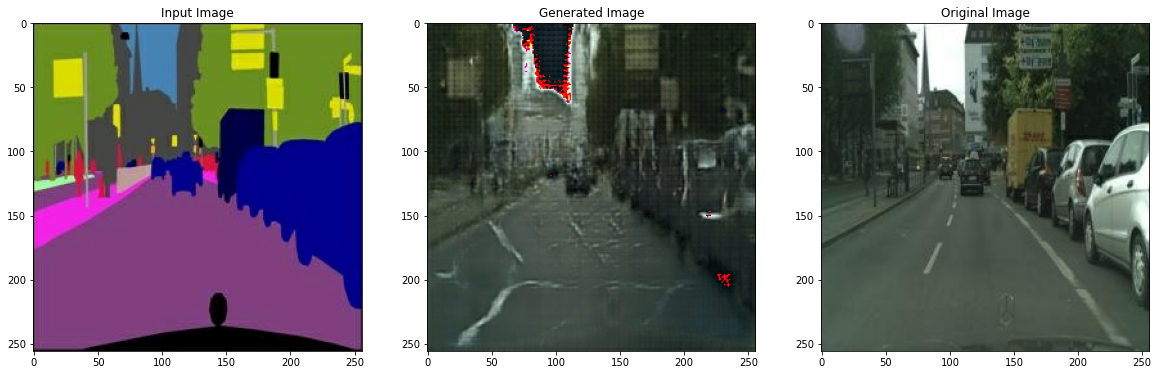

In [20]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.title('Input Image')
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.title('Generated Image')
plt.subplot(1,3,3); plt.imshow(denormalize(colored))
plt.title('Original Image')

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
- GAN을 활용하는 다양한 개념들에 대해 배웠는데 생각보다 이론적인 부분을 이해하는게 어려웠다.   
- 마지막 시각화 부분에서 모델을 저장해놓지 않아서 학습시켜놓은 모델이 증발해버렸다...

   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
- 이전부터 생각해오던대로 GAN은 정말 활용할 수 있는 분야가 많을 것이라 생각했다. 예상한대로, pix2pix를 사용하면 원하는 이미지를 기반으로 새로운 이미지를 생성해낼 수 있었고 굉장히 흥미로웠다.   
- 이번 해커톤 2차에서도 GAN을 활요한 모델로 진행하려고 하는데, 이번에 사용한 Pix2pix를 사용하면 더 좋은 결과물을 낼 수 있을것 같아 기대가 된다.


## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
   
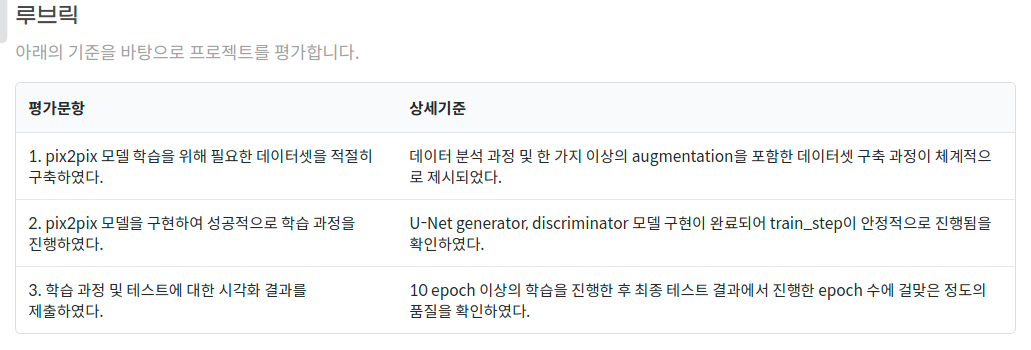
- pix2pix 모델 학습을 위해 데이터셋을 적절히 구축하였다.   
- 성공적으로 학습 과정을 진행하였다.   
- 시각화 결과를 제출하였다 (100에폭보다 좋지 못한 결과가 나와서 아쉽다...)

   
## 4. **자기 다짐**   
- 앞서 언급한 것처럼 이번 해커톤에서 GAN을 사용한 비즈니스 모델을 계획하고 있다. 무에서 유를 창출하는 GAN의 특징에 중점을 두어 새로운 것을 만들어야 하는 곳에 사용할 수 있도록 계획서를 작성중이다. 공을 들여서 내가 계획하고 원하는 프로젝트를 진행할 수 있었으면 좋겠다.